Saving Contact-diaries-network_data_2013.csv to Contact-diaries-network_data_2013 (5).csv
Top 10 Superspreaders:
      deg  wt_sum  sup_score
15     16      35        560
845    16      27        432
1295   17      22        374
945    17      22        374
448    14      26        364
407    17      21        357
866    12      29        348
468    12      25        300
200    13      23        299
471    13      22        286


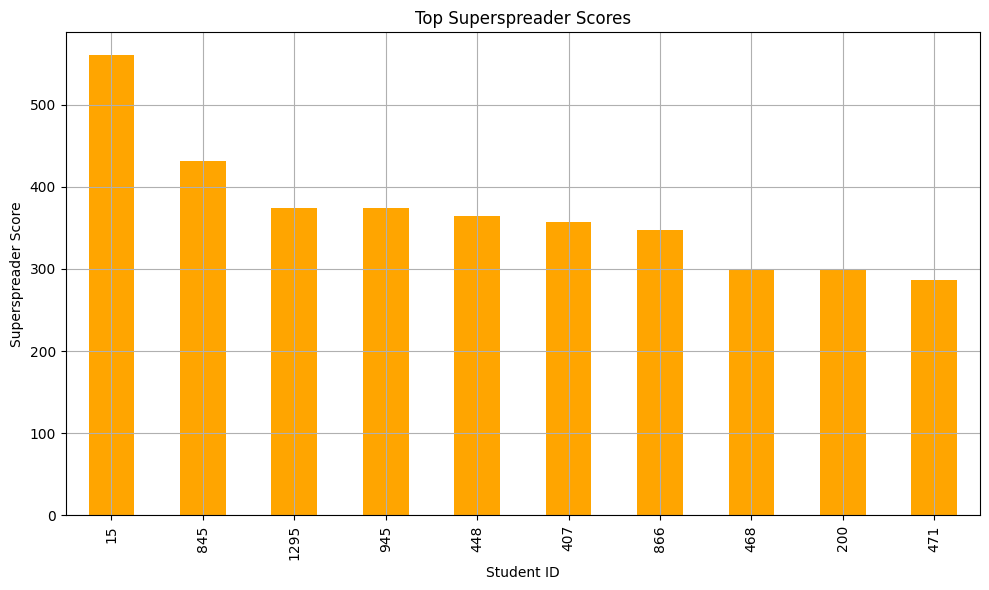

In [19]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload() # upload Contact-diaries-network_data_2013.csv

df = pd.read_csv(next(iter(uploaded)), sep=' ', header=None, names=['src', 'tgt', 'wt'])

dur_map = {1: '≤5 min', 2: '5–15 min', 3: '15–60 min', 4: '>60 min'}
df['dur_cat'] = df['wt'].map(dur_map)

G = nx.DiGraph()
for _, r in df.iterrows():
    G.add_edge(r['src'], r['tgt'], wt=r['wt'])

deg = dict(G.degree())
wt = {n: 0 for n in G.nodes()}
for u, v, d in G.edges(data=True):
    wt[u] += d['wt']

score = pd.DataFrame({'deg': pd.Series(deg), 'wt_sum': pd.Series(wt)})
score['sup_score'] = score['deg'] * score['wt_sum']
score = score.sort_values(by='sup_score', ascending=False)

TOP_N = 10
print(f"Top {TOP_N} Superspreaders:")
print(score.head(TOP_N))

plt.figure(figsize=(10, 6))
score['sup_score'].head(TOP_N).plot(kind='bar', color='orange')
plt.title('Top Superspreader Scores')
plt.xlabel('Student ID')
plt.ylabel('Superspreader Score')
plt.grid(True)
plt.tight_layout()
plt.show()


Saving Contact-diaries-network_data_2013.csv to Contact-diaries-network_data_2013 (7).csv


Saving mt actual.txt to mt actual (4).txt
No valid seeds found for class PSI*
No valid seeds found for class PC*


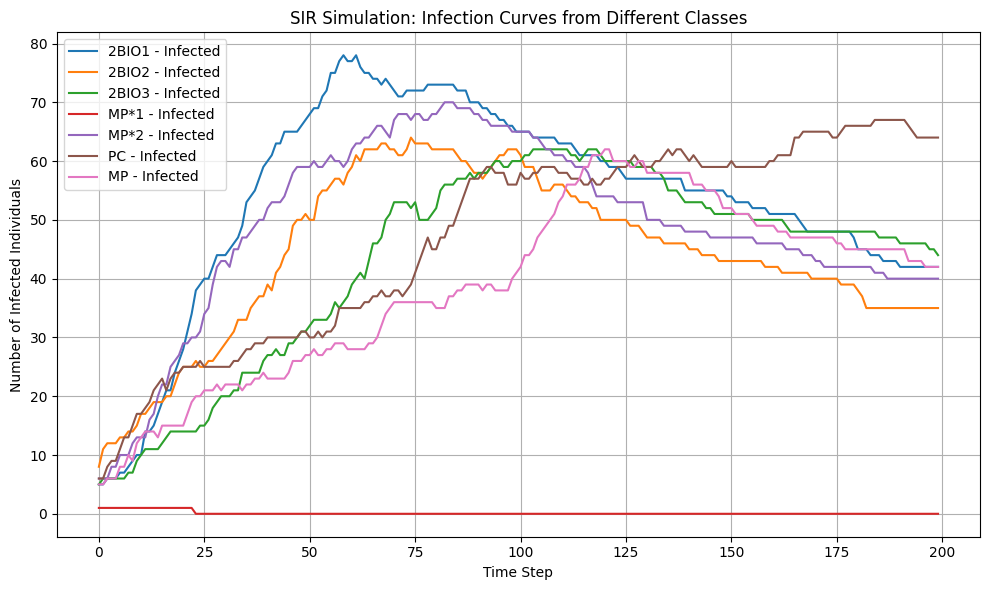

2BIO1: Time to 50% spread: 40 steps
2BIO2: Time to 50% spread: 61 steps
2BIO3: Time to 50% spread: 94 steps
MP*1: Time to 50% spread: None steps
MP*2: Time to 50% spread: 51 steps
PC: Time to 50% spread: 126 steps
MP: Time to 50% spread: 117 steps


In [22]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files

# Upload the contact network file (Contact-diaries-network_data_2013.csv)
uploaded = files.upload()
filename = next(iter(uploaded))


df_raw = pd.read_csv(filename, header=None, sep=" ")
df_raw.columns = ['Source', 'Target', 'Weight']
df_raw = df_raw.astype(int)
G_phys = nx.DiGraph()
G_phys.add_weighted_edges_from(df_raw.values)

# Upload and read the metadata file (mt actual)
uploaded_metadata = files.upload()
metadata_filename = next(iter(uploaded_metadata))
df_metadata = pd.read_csv(metadata_filename, sep='\t', header=None, names=['ID', 'Class', 'Gender'])



id_to_class = pd.Series(df_metadata.Class.values, index=df_metadata.ID).to_dict()
id_to_gender = pd.Series(df_metadata.Gender.values, index=df_metadata.ID).to_dict()
def get_valid_initial_seeds(class_seeds):
    valid_seeds = [seed for seed in class_seeds if seed in G_phys.nodes()]
    if not valid_seeds:
        print(f"Warning: No valid seeds found for class with IDs: {class_seeds}")
    return valid_seeds

# SIR simulation
def run_sir_simulation(G, beta=0.05, gamma=0.005, initial_infected=None, max_steps=200): # Increased beta, decreased gamma, increased max_steps
    susceptible = set(G.nodes())
    infected = set(initial_infected if initial_infected else [random.choice(list(G.nodes()))])
    recovered = set()
    susceptible -= infected

    history = []

    for step in range(max_steps):
        new_infected = set()
        new_recovered = set()

        for node in infected:
            for neighbor in G.neighbors(node):
                if neighbor in susceptible and random.random() < beta:
                    new_infected.add(neighbor)
            if random.random() < gamma:
                new_recovered.add(node)

        infected |= new_infected
        infected -= new_recovered
        susceptible -= new_infected
        recovered |= new_recovered

        history.append({
            'step': step,
            'S': len(susceptible),
            'I': len(infected),
            'R': len(recovered)
        })

        # Removing the early stopping condition for now to see the full curves
        # if len(infected) / len(G.nodes()) >= 0.5:
        #     break

    return history



classes = df_metadata['Class'].unique()
genders = df_metadata['Gender'].unique()
class_seeds = {class_name: df_metadata[df_metadata['Class'] == class_name]['ID'].tolist() for class_name in classes}
gender_seeds = {gender: df_metadata[df_metadata['Gender'] == gender]['ID'].tolist() for gender in genders}

results = {}

plt.figure(figsize=(10, 6))

# Simulations
for class_name, initial_seeds in class_seeds.items():
    valid_seeds = get_valid_initial_seeds(initial_seeds)
    if not valid_seeds:
        print(f"No valid seeds found for class {class_name}")
        continue

    sir_result = run_sir_simulation(G_phys, beta=0.05, gamma=0.005, initial_infected=valid_seeds[:5], max_steps=200) # Using modified parameters and max_steps
    infected_vals = [x['I'] for x in sir_result]
    time_to_50_percent = next((i for i, val in enumerate(infected_vals) if val / len(G_phys.nodes()) >= 0.5), None)

    results[class_name] = {
        'sir_result': sir_result,
        'time_to_50_percent': time_to_50_percent
    }

    # Plotting the infection curves
    I_vals = [x['I'] for x in sir_result]
    plt.plot(I_vals, label=f'{class_name} - Infected')



plt.title("SIR Simulation: Infection Curves from Different Classes")
plt.xlabel("Time Step")
plt.ylabel("Number of Infected Individuals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


for class_name, result in results.items():
    print(f"{class_name}: Time to 50% spread: {result['time_to_50_percent']} steps")

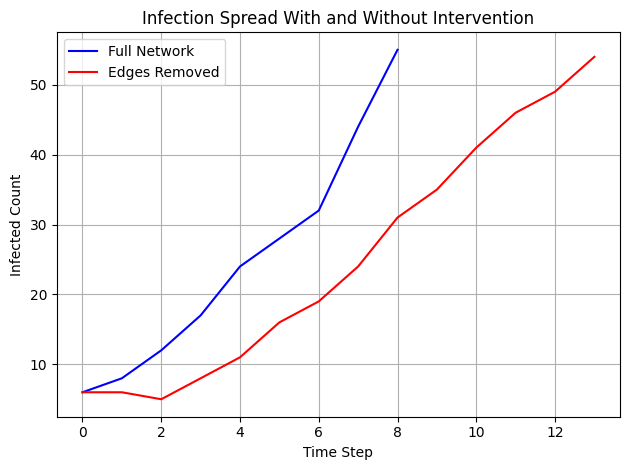

Time to 50% spread (Full Network): 8 steps
Time to 50% spread (Edges Removed): 13 steps


In [17]:
import networkx as nx
import random
import matplotlib.pyplot as plt

def link_betweenness(G):
    return nx.edge_betweenness_centrality(G)

def remove_top_edges(G, frac=0.1):
    bw = link_betweenness(G)
    n = int(frac * len(bw))
    top_edges = sorted(bw, key=bw.get, reverse=True)[:n]
    G_mod = G.copy()
    G_mod.remove_edges_from(top_edges)
    return G_mod

def sir(G, beta=0.1, gamma=0.01, seed=None, steps=200):
    S = set(G.nodes())
    I = set(seed if seed else random.sample(list(G.nodes()), 5))
    R = set()
    S -= I

    hist = []

    for t in range(steps):
        new_I = set()
        new_R = set()

        for u in I:
            for v in G.neighbors(u):
                if v in S and random.random() < beta:
                    new_I.add(v)
            if random.random() < gamma:
                new_R.add(u)

        I |= new_I
        I -= new_R
        S -= new_I
        R |= new_R

        hist.append({'step': t, 'S': len(S), 'I': len(I), 'R': len(R)})

        if len(I) / len(G.nodes()) >= 0.5:
            break

    return hist

def simulate(G, beta=0.1, gamma=0.01, steps=200):
    res_full = sir(G, beta=beta, gamma=gamma, steps=steps)
    G_cut = remove_top_edges(G)
    res_cut = sir(G_cut, beta=beta, gamma=gamma, steps=steps)
    return res_full, res_cut

G = nx.erdos_renyi_graph(100, 0.05)
res_full, res_cut = simulate(G)

I_full = [x['I'] for x in res_full]
I_cut = [x['I'] for x in res_cut]

plt.plot(I_full, label='Full Network', color='blue')
plt.plot(I_cut, label='Edges Removed', color='red')
plt.title("Infection Spread With and Without Intervention")
plt.xlabel("Time Step")
plt.ylabel("Infected Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

t50_full = next((i for i, x in enumerate(I_full) if x / len(G) >= 0.5), None)
t50_cut = next((i for i, x in enumerate(I_cut) if x / len(G) >= 0.5), None)

print(f"Time to 50% spread (Full Network): {t50_full} steps")
print(f"Time to 50% spread (Edges Removed): {t50_cut} steps")
